In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('Data/processed_train.csv')
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


In [3]:
data.HasDetections.value_counts()

HasDetections
0    99940
1    20012
Name: count, dtype: int64

Разделим выборку на тренировочную и тестовую

In [11]:
y = data['HasDetections']
X = data.drop('HasDetections', axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=1)

Обучите логистическую регрессию на тренировочной части наших данных, используя класс `LogisticRegression` из `sklearn.linear_model` с `l2` регуляризацией и коэффициентом регуляризации `C=0.01`. Ваш estimator должен нормировать данные по статистикам, рассчитывающимся на тренировочной выборке. Придется использовать конструкцию `Pipeline`. Положите все в переменную `pipe`.

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

### Your code is here

pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ('logreg', LogisticRegression(penalty='l2', C=0.01))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test).__round__(2)

0.84

In [65]:
from sklearn.metrics import classification_report

print(classification_report(y_pred=pipe.predict(X_test), y_true=y_test))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91     25019
           1       0.64      0.11      0.18      4969

    accuracy                           0.84     29988
   macro avg       0.75      0.55      0.55     29988
weighted avg       0.81      0.84      0.79     29988



Постройте ROC-кривую с помощью `RocCurveDisplay` и посчитайте `ROC-AUC` любым из показанных на практике способов. Один из вариантов - построить кривую с помощью `roc_curve` из `sklearn.metrics` и массивы пар `tpr-fpr` передать в `auc` из того же модуля `sklearn`. Проделайте эту операцию как для предсказаний на трейне, так и на тесте!

P.S. `roc_curve` необходимо скормить истинные метки классов (y_train/y_test), а также предсказанные вероятности (воспользуйтесь методом `predict_proba`)

0.6991002252302182

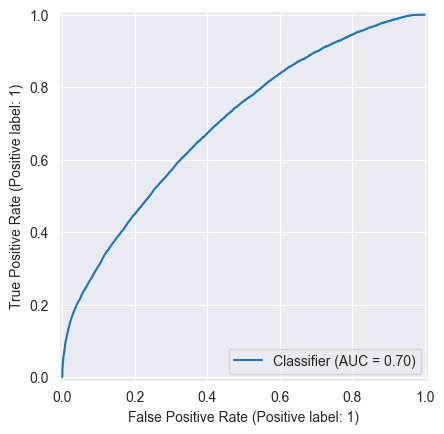

In [58]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc

### На трейне
### Your code is here
fpr, tpr, thresholds = roc_curve(y_train, pipe.predict_proba(X_train)[:, 1])
RocCurveDisplay.from_predictions(y_train, pipe.predict_proba(X_train)[:, 1])
auc(fpr, tpr)

0.6968394420723245

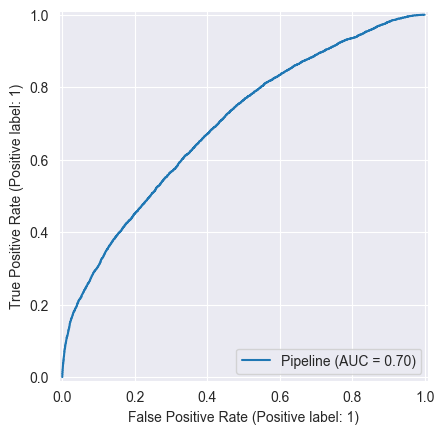

In [59]:
### На тесте
### Your code is here
fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(X_test)[:, 1])
RocCurveDisplay.from_estimator(estimator=pipe, y=y_test, X=X_test)
auc(fpr, tpr)

Постройте PR-кривые на трейне и на тесте. Посчитайте PR-AUC

0.366

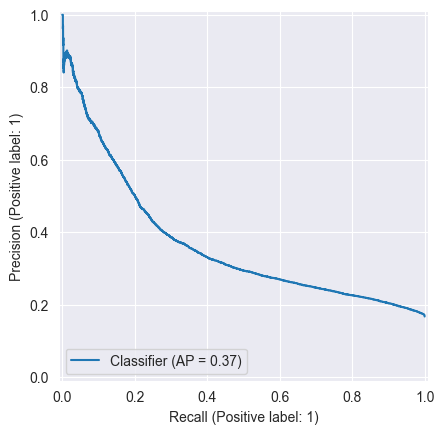

In [78]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
### На трейне
### Your code is here

precision, recall, thresholds = precision_recall_curve(y_train, pipe.predict_proba(X_train)[:, 1])
PrecisionRecallDisplay.from_predictions(y_train, pipe.predict_proba(X_train)[:, 1])
auc(x=recall, y=precision).__round__(3)

0.359

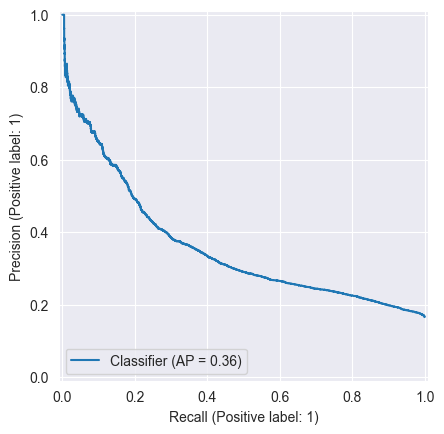

In [77]:
### На тесте
### Your code is here
precision, recall, thresholds = precision_recall_curve(y_test, pipe.predict_proba(X_test)[:, 1])
PrecisionRecallDisplay.from_predictions(y_test, pipe.predict_proba(X_test)[:, 1])
auc(x=recall, y=precision).__round__(3)

Построим калибровочную кривую. Хорошо ли откалиброван обученный классификатор? Сравним с калибровочной кривой для случайного классификатора!

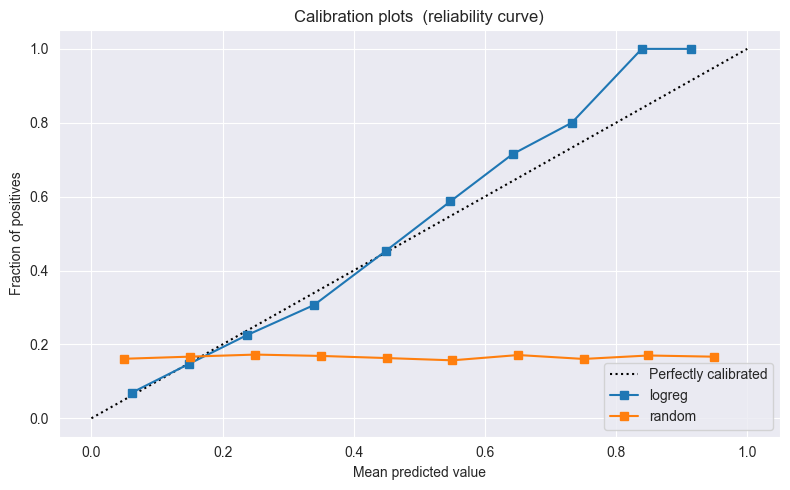

In [79]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

### Предсказания модели на тесте и соответствующая калибровочная кривая
prob_pos = pipe.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg")

### Пусть наши предсказания - случайные, то есть для каждого объекта
### вероятность принадлежности + классу это просто случайное число [0; 1]
prob_pos = np.random.uniform(size=(X_test.shape[0],))
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="random")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.tight_layout()

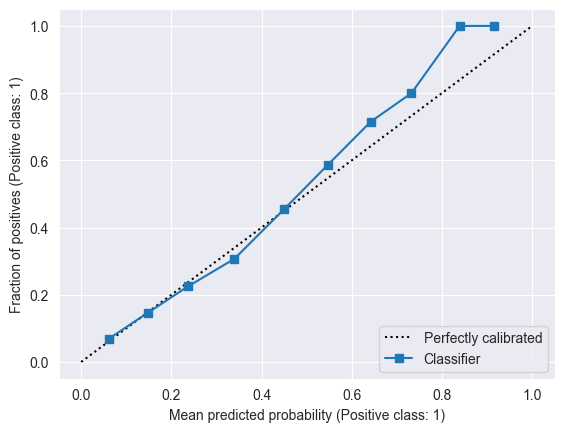

In [81]:
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_predictions(y_test, pipe.predict_proba(X_test)[:, 1], n_bins=10)